In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import pydot

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Restrict permissions

In [4]:
!kaggle datasets download alvinbintang/sibi-dataset

Dataset URL: https://www.kaggle.com/datasets/alvinbintang/sibi-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:22<00:00, 306MB/s]
100% 2.70G/2.70G [00:22<00:00, 129MB/s]


In [5]:
!unzip /content/sibi-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: SIBI/B/1645946451.0243402_B.jpg  
  inflating: SIBI/B/1645946454.6260056_U.jpg  
  inflating: SIBI/B/1645946456.4885087_F.jpg  
  inflating: SIBI/B/1645946460.4972847_B.jpg  
  inflating: SIBI/B/1645946463.7729926_B.jpg  
  inflating: SIBI/B/1645946467.532869_B.jpg  
  inflating: SIBI/B/1645949132.0273714_B.jpg  
  inflating: SIBI/B/1645949136.465165_B.jpg  
  inflating: SIBI/B/1645949142.7455149_B.jpg  
  inflating: SIBI/B/1645949858.470701_Q.jpg  
  inflating: SIBI/B/1645949859.1649747_C.jpg  
  inflating: SIBI/B/1645949859.858002_Q.jpg  
  inflating: SIBI/B/1645949860.5160742_G.jpg  
  inflating: SIBI/B/1645949860.9303768_C.jpg  
  inflating: SIBI/B/1645949863.3891625_C.jpg  
  inflating: SIBI/B/1645949864.6113553_C.jpg  
  inflating: SIBI/B/1645950338.9793453_C.jpg  
  inflating: SIBI/B/1645950339.6984558_C.jpg  
  inflating: SIBI/B/1645950340.2939713_C.jpg  
  inflating: SIBI/B/1645950341.0949953_C.jpg  
  inflating: 

In [6]:
def load_dataset(directory):
  images = []
  labels = []
  for idx, label in enumerate(uniq_labels):
    folder_path = os.path.join(directory, label)  # Construct full folder path
    if os.path.exists(folder_path):  # Check if folder exists
      for file in os.listdir(folder_path):
        filepath = os.path.join(folder_path, file)
        img = cv2.resize(cv2.imread(filepath),(50,50))
        images.append(img)
        labels.append(idx)
  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

In [7]:
#display_images function to show examples
def display_images(x_data,y_data, title, display_label = True):
    x, y = x_data,y_data
    fig, axes = plt.subplots(5, 8, figsize = (18, 5))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    fig.suptitle(title, fontsize = 18)
    for i, ax in enumerate(axes.flat):
        # Convert the image to uint8 before using cv2.cvtColor
        ax.imshow(cv2.cvtColor(x[i].astype(np.uint8), cv2.COLOR_BGR2RGB))
        if display_label:
            ax.set_xlabel(uniq_labels[y[i]])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [8]:
#loading_dataset into X_pre and Y_pre
data_dir = "/content/SIBI"  # Root directory for SIBI dataset
uniq_labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # Labels A to Z
X_pre, Y_pre = load_dataset(data_dir)
print(X_pre.shape, Y_pre.shape)

(5280, 50, 50, 3) (5280,)


In [9]:
#spliting dataset into 80% train, 20% test data
X_train, X_test, Y_train, Y_test = train_test_split(X_pre, Y_pre, train_size = 0.8)
X_test, X_eval, Y_test, Y_eval = train_test_split(X_test, Y_test, test_size = 0.2)

Train images shape (4224, 50, 50, 3) (4224,)
Test images shape (844, 50, 50, 3) (844,)
Evaluate image shape (212, 50, 50, 3) (212,)
Printing the labels ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] 26


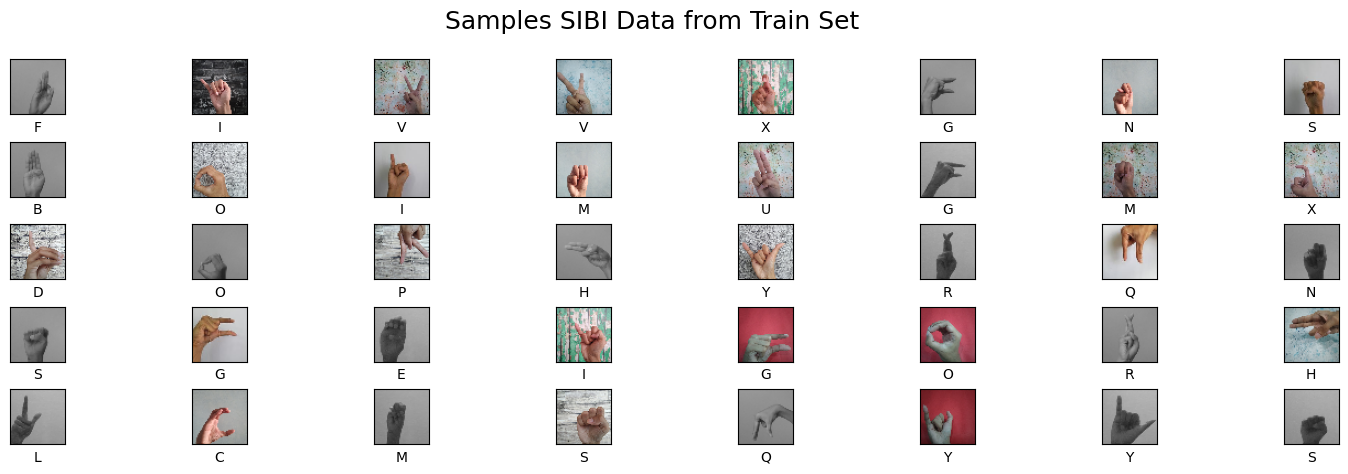

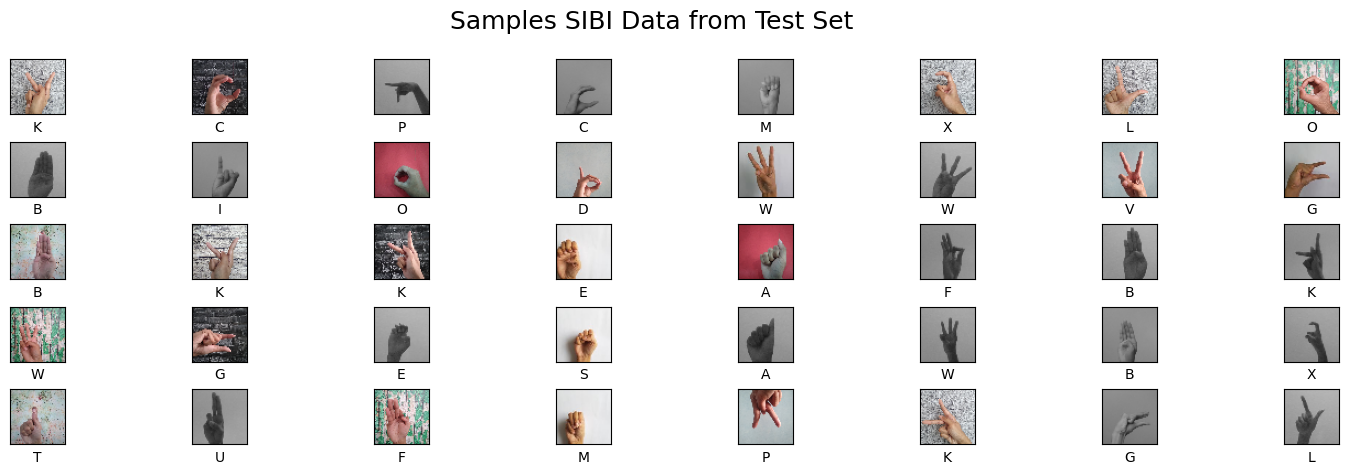

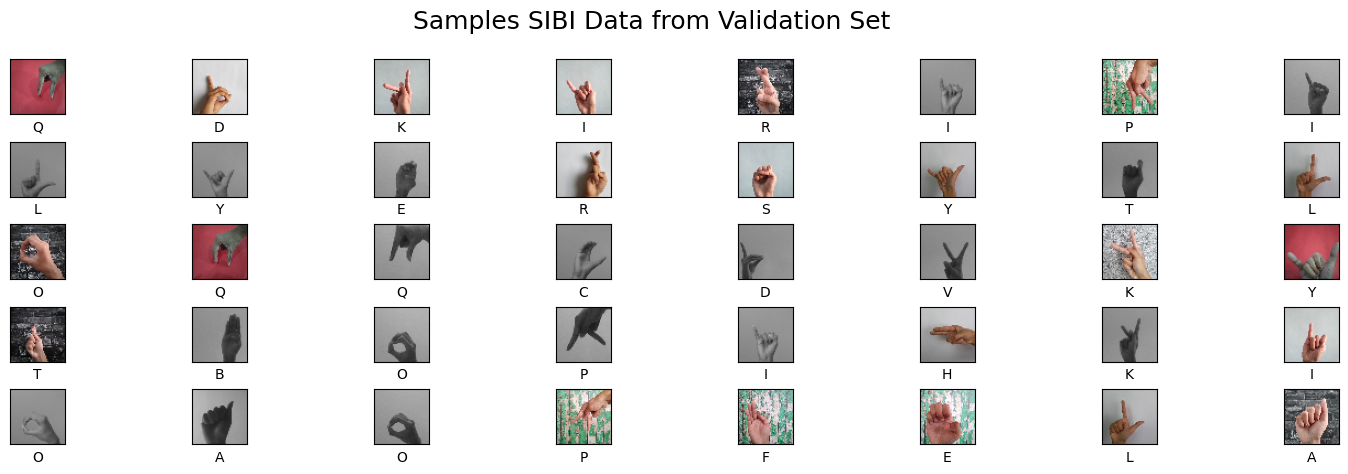

In [10]:
#print shapes and show examples for each set
print("Train images shape",X_train.shape, Y_train.shape)
print("Test images shape",X_test.shape, Y_test.shape)
print("Evaluate image shape",X_eval.shape, Y_eval.shape)
print("Printing the labels",uniq_labels, len(uniq_labels))
display_images(X_train,Y_train,'Samples SIBI Data from Train Set')
display_images(X_test,Y_test,'Samples SIBI Data from Test Set')
display_images(X_eval,Y_eval,'Samples SIBI Data from Validation Set')

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(X_train)

In [12]:
# converting Y_tes and Y_train to One hot vectors using to_categorical
# Convert Y_train, Y_test, and Y_eval to one-hot vectors using to_categorical
Y_train = to_categorical(Y_train, num_classes=len(uniq_labels))
Y_test = to_categorical(Y_test, num_classes=len(uniq_labels))
Y_eval = to_categorical(Y_eval, num_classes=len(uniq_labels))
X_train = X_train / 255.
X_test = X_test/ 255.
X_eval = X_eval/ 255.

In [14]:
model = tf.keras.Sequential([
        # Input Layer
        tf.keras.Input(shape=(50,50,3)),

        # Initial Convolution Block
        layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),  # Light dropout early

        # Block 1 - Feature Extraction
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2 - Deeper Feature Learning
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3 - High-level Features
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0005)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Global Average Pooling (reduces overfitting better than Flatten)
        layers.GlobalAveragePooling2D(),

        # Classification Head with Progressive Dropout
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(26, activation='softmax')
    ])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 366,250 (1.40 MB)

 Trainable params: 364,522 (1.39 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
!pip install pydot
!apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


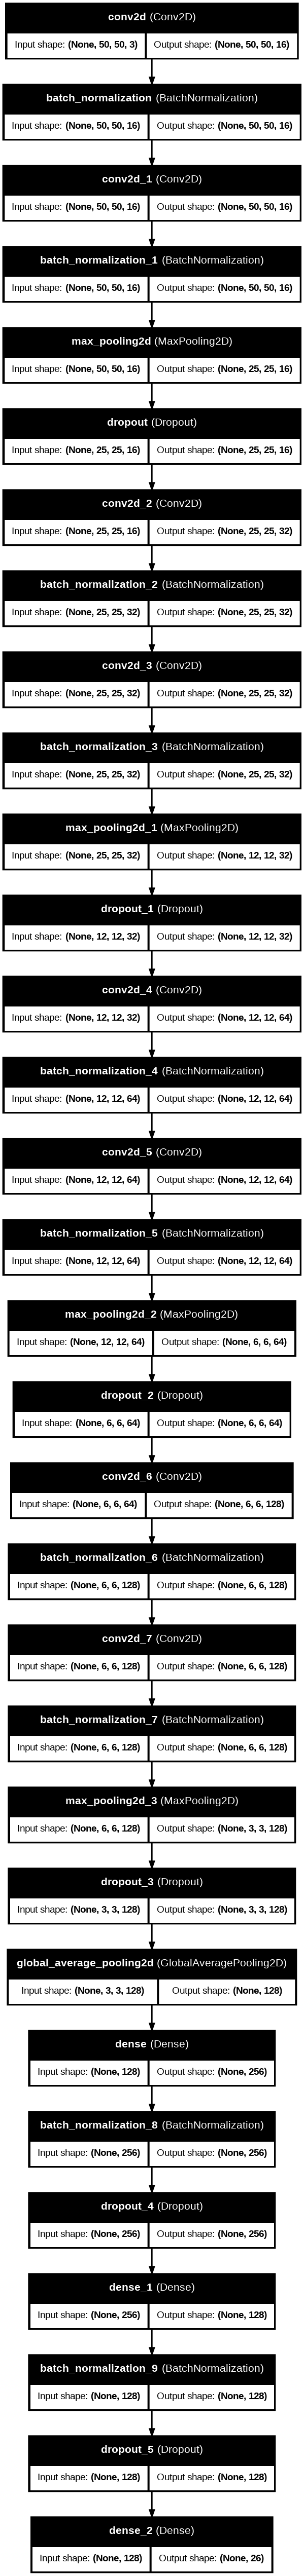

In [15]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Plot the model architecture
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # 'TB' for vertical, 'LR' for horizontal layout
    dpi=96,
    expand_nested=False  # Set to True if using nested models
)

# Display the image in the notebook
Image('model_architecture.png')

In [34]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']  # Additional metrics for better monitoring
)

In [35]:
def get_callbacks():
    callbacks = [
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),

        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1),
    ]
    return callbacks

In [37]:
print("Y_eval shape:", Y_eval.shape)  # Add this line for debugging
history = model.fit(X_train, Y_train, batch_size=32, epochs=250, validation_data=(X_eval, Y_eval), callbacks=get_callbacks())

Y_eval shape: (212, 26)
Epoch 1/250
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7550 - loss: 1.2291 - val_accuracy: 0.8821 - val_loss: 0.8760 - learning_rate: 0.0010
Epoch 2/250
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7731 - loss: 1.1809 - val_accuracy: 0.8349 - val_loss: 0.9116 - learning_rate: 0.0010
Epoch 3/250
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7718 - loss: 1.1172 - val_accuracy: 0.8868 - val_loss: 0.8121 - learning_rate: 0.0010
Epoch 4/250
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7955 - loss: 1.0922 - val_accuracy: 0.9198 - val_loss: 0.7882 - learning_rate: 0.0010
Epoch 5/250
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8089 - loss: 1.0251 - val_accuracy: 0.9009 - val_loss: 0.7665 - learning_rate: 0.0010
Epoch 6/250
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7962 - loss: 1.0405 - val_accuracy: 0.9104 - val_loss: 0.7658 - learning_rate: 0.0010
Epoch 7/250
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc

In [42]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

In [43]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9748 - loss: 0.3488
Test Loss: 0.3195
Test Accuracy: 0.9810


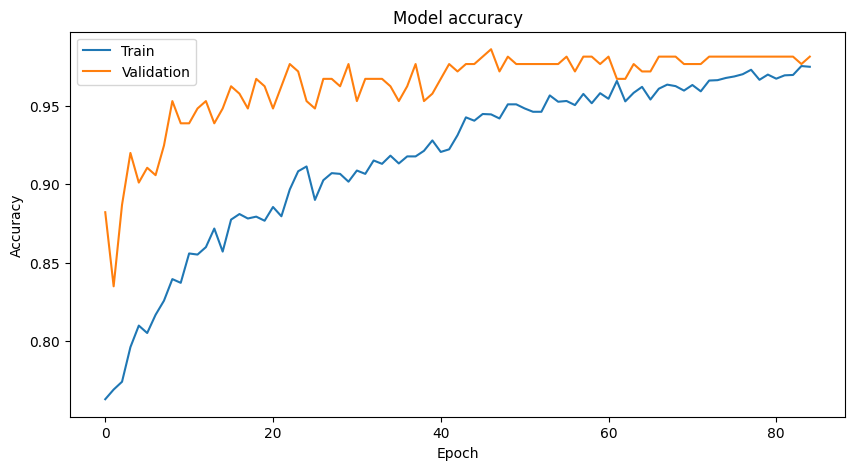

In [44]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

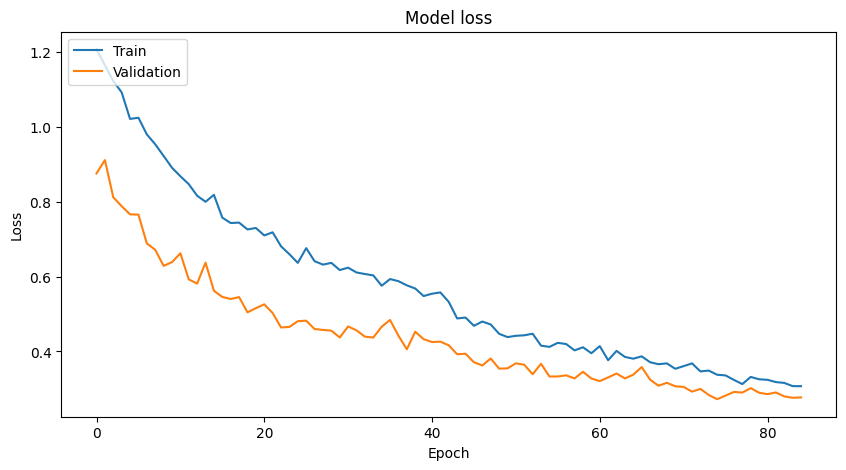

In [45]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
Classification Report:
               precision    recall  f1-score   support

           A       0.89      1.00      0.94         8
           B       1.00      1.00      1.00         7
           C       1.00      1.00      1.00        10
           D       1.00      1.00      1.00         8
           E       1.00      1.00      1.00        13
           F       1.00      1.00      1.00         6
           G       1.00      1.00      1.00         6
           H       1.00      1.00      1.00        10
           I       1.00      1.00      1.00        16
           K       1.00      1.00      1.00         7
           L       1.00      1.00      1.00         8
           M       0.92      1.00      0.96        12
           N       1.00      1.00      1.00         9
           O       1.00      1.00      1.00        14
           P       0.92      1.00      0.96        12
           Q       1.00      0.89      0.94         9
           R      

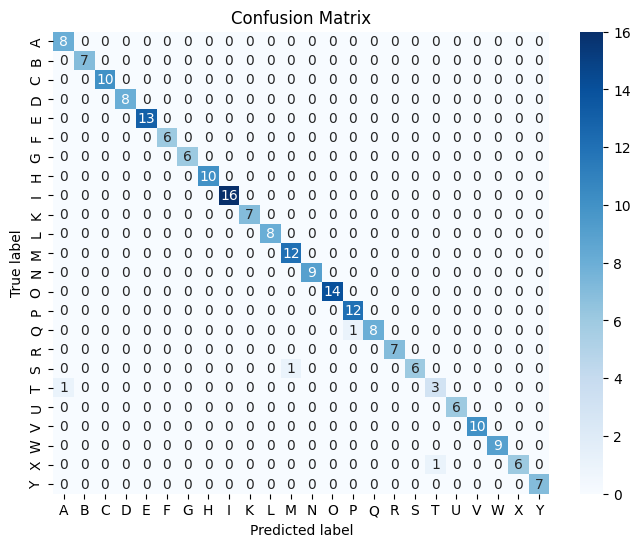

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the predicted probabilities for each class
Y_pred_probs = model.predict(X_eval)

# Get the predicted class indices
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Get the true class indices (assuming Y_eval is one-hot encoded)
Y_true = np.argmax(Y_eval, axis=1)

# Get unique labels present in the data
unique_labels_present = np.unique(Y_true)

# Filter uniq_labels to include only present labels
target_names_present = [uniq_labels[i] for i in unique_labels_present]


# Classification Report
print("Classification Report:\n", classification_report(Y_true, Y_pred, target_names=target_names_present))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, Y_pred)

# Visualisasi Confusion Matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_present, yticklabels=target_names_present)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [47]:
from sklearn.metrics import confusion_matrix

# Assuming you have Y_true (true labels) and Y_pred (predicted labels)
uniq_labels = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred)

# Get the labels present in the confusion matrix
labels_present = np.unique(np.concatenate((Y_true, Y_pred)))

# Iterate through each class present in the data
for i, label_index in enumerate(labels_present):
    label = uniq_labels[label_index]  # Get the corresponding label from uniq_labels
    TP = conf_matrix[i, i]
    FP = conf_matrix[i, :].sum() - TP  # Sum of FP for the current class
    FN = conf_matrix[:, i].sum() - TP  # Sum of FN for the current class
    TN = conf_matrix.sum() - (TP + FP + FN)  # Sum of TN for the current class

    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0  # Handle zero division
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0  # Handle zero division
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0  # Handle zero division
    accuracy = (TP + TN) / (TP + FP + TN + FN)

    # Print results for the current class
    print(f"Metrics for class {label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1_score:.4f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print("-" * 20)  # Separator for better readability

Metrics for class A:
  Precision: 1.0000
  Recall: 0.8889
  F1-score: 0.9412
  Accuracy: 0.9953
--------------------
Metrics for class B:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Accuracy: 1.0000
--------------------
Metrics for class C:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Accuracy: 1.0000
--------------------
Metrics for class D:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Accuracy: 1.0000
--------------------
Metrics for class E:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Accuracy: 1.0000
--------------------
Metrics for class F:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Accuracy: 1.0000
--------------------
Metrics for class G:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Accuracy: 1.0000
--------------------
Metrics for class H:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Accuracy: 1.0000
--------------------
Metrics for class I:
  Precision: 1.0000
  Recall: 1.0000
  F1-s

In [48]:
# prompt: save model into .h5

model.save("sibi_model.h5")